# Real fields - Maxey-Riley equations slow manifold

In [2]:
from typing import Any, Callable, Dict
import json

import cartopy.crs as ccrs
import cmocean.cm as cmo
import diffrax as dfx
import equinox as eqx
import interpax as ipx
import jax
import jax.numpy as jnp
from jaxtyping import Array, Float, Int, PyTree, Real
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from jaxparrow import cyclogeostrophy
from jaxparrow.tools.operators import interpolation

from pastax.gridded import Gridded, spatial_derivative
from pastax.simulator import DeterministicSimulator, DiffraxSimulator
from pastax.trajectory import Location, Trajectory
from pastax.utils import distance_on_earth, meters_to_degrees, degrees_to_meters

from matplotlib import animation
from IPython.display import HTML



In [3]:
# Figure styling
from matplotlib import rc
import matplotlib as mpl
fs = 12
rc('legend', fontsize=fs)
rc('axes',   labelsize=fs)
rc('xtick',  labelsize=fs)
rc('ytick',  labelsize=fs)
rc('lines',  markersize=7)
rc('lines',  linewidth=1.5)
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']+ mpl.rcParams['font.serif']
mpl.rcParams["mathtext.fontset"] = "stix"
#mpl.rcParams['text.usetex'] = True

In [4]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_disable_jit", False)

## Input data

In [5]:
data_path = '/home/samantha/Documents/SL/measurements/' # samantha
#data_path = '/Users/bertrava/projects/oct25/data/' # vadim

### Drifter trajectories

In [6]:
start_time = np.datetime64("2025-04-25T19:00:00")
horizon_days = 7

In [7]:
drifters_dir = data_path + "otc25_trajectories_20250505"

In [8]:
def get_trajectory(drifter_name: str) -> Trajectory:
    with open(f"{drifters_dir}/{drifter_name}.json") as f:
        traj_json = json.load(f)

        ts = []
        lat = []
        lon = []
        t0 = None
        for sample in traj_json:
            t = sample["time"]
            
            if np.datetime64(t) < start_time:
                continue
            if t0 is None:
                t0 = np.datetime64(t)
            if np.datetime64(t) > start_time + np.timedelta64(horizon_days, "D"):
                break

            ts.append(t)
            lat.append(sample["lat"])
            lon.append(sample["lon"])

        return Trajectory.from_array(
            jnp.stack((jnp.asarray(lat), jnp.asarray(lon)), axis=-1), 
            jnp.asarray(np.asarray(ts).astype("datetime64[s]").astype(int))
        )

In [9]:
melodi_traj = get_trajectory("301434060093370")
melodi_x0 = melodi_traj.origin
melodi_ts = melodi_traj.times.value

/tmp/ipykernel_15164/3248268503.py:12: UserWarning: no explicit representation of timezones available for np.datetime64
  if np.datetime64(t) < start_time:
/tmp/ipykernel_15164/3248268503.py:15: UserWarning: no explicit representation of timezones available for np.datetime64
  t0 = np.datetime64(t)
/tmp/ipykernel_15164/3248268503.py:16: UserWarning: no explicit representation of timezones available for np.datetime64
  if np.datetime64(t) > start_time + np.timedelta64(horizon_days, "D"):
/tmp/ipykernel_15164/3248268503.py:25: UserWarning: no explicit representation of timezones available for np.datetime64
  jnp.asarray(np.asarray(ts).astype("datetime64[s]").astype(int))

In [10]:
omb_traj = get_trajectory("OMB-2024-04")
omb_x0 = omb_traj.origin
omb_ts = omb_traj.times.value

/tmp/ipykernel_15164/3248268503.py:12: UserWarning: no explicit representation of timezones available for np.datetime64
  if np.datetime64(t) < start_time:
/tmp/ipykernel_15164/3248268503.py:15: UserWarning: no explicit representation of timezones available for np.datetime64
  t0 = np.datetime64(t)
/tmp/ipykernel_15164/3248268503.py:16: UserWarning: no explicit representation of timezones available for np.datetime64
  if np.datetime64(t) > start_time + np.timedelta64(horizon_days, "D"):
/tmp/ipykernel_15164/3248268503.py:25: UserWarning: no explicit representation of timezones available for np.datetime64
  jnp.asarray(np.asarray(ts).astype("datetime64[s]").astype(int))

Trajectories during a week of drifters deployed on April 24th on the Lofoten Vortex

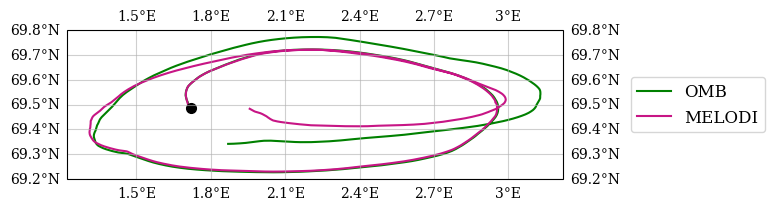

In [11]:
import cartopy.crs as ccrs


fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.plot(omb_traj.value[:,1], omb_traj.value[:,0], c='green', label = 'OMB')
ax.plot(melodi_traj.value[:,1], melodi_traj.value[:,0], c='mediumvioletred', label = 'MELODI')
ax.plot(melodi_traj.value[0,1], melodi_traj.value[0,0], 'ko')

ax.legend(loc='center left', bbox_to_anchor=(1.12, 0.5))
ax.coastlines()
ax.gridlines(alpha=0.6, draw_labels=True)

### Forcings

In [12]:
min_lat, max_lat = (melodi_x0.latitude - 2).value.item(), (melodi_x0.latitude + 2).value.item()
min_lon, max_lon = (melodi_x0.longitude - 2).value.item(), (melodi_x0.longitude + 2).value.item()
min_time = start_time.astype("datetime64[D]")
max_time = start_time.astype("datetime64[D]") + np.timedelta64(1 + horizon_days, "D")

In [13]:
def get_latlon_from_idf(ds: xr.Dataset) -> (np.ndarray, np.ndarray):
    def do_transform(coord_name: str):
        d = np.diff(ds[f"{coord_name}_gcp"])[0] / np.diff(ds[f"index_{coord_name}_gcp"].values.ravel())[0]
        c0 = float(np.round(ds[f"{coord_name}_gcp"].min().values + d / 2, 3))
        return c0 + ds[coord_name].values * d
    return do_transform("lat"), do_transform("lon")

In [14]:
def preproc_fn(ds: xr.Dataset) -> xr.Dataset:
    ds["lat"], ds["lon"] = get_latlon_from_idf(ds)
    return ds.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

### Vardyn - cyclogeostrophy

In [15]:
vardyn_dir = data_path + "Vardyn"

In [16]:
vardyn_ds = xr.open_dataset(f"{vardyn_dir}/VarDyn_SWOT_2025-03-13_2025-05-12.nc")
vardyn_ds = vardyn_ds.sel(
    time=slice(min_time, max_time), 
    lat=slice(min_lat, max_lat), 
    lon=slice(min_lon, max_lon)
)
vardyn_ds

<xarray.Dataset> Size: 2MB
Dimensions: (time: 9, lat: 80, lon: 80)
Coordinates:
 * time (time) datetime64[ns] 72B 2025-04-25 2025-04-26 ... 2025-05-03
 * lat (lat) float64 640B 67.5 67.55 67.6 67.65 ... 71.3 71.35 71.4 71.45
 * lon (lon) float64 640B -0.25 -0.2 -0.15 -0.1 ... 3.55 3.6 3.65 3.7
Data variables:
 sla (time, lat, lon) float64 461kB ...
 ssh (time, lat, lon) float64 461kB ...
 u (time, lat, lon) float64 461kB ...
 v (time, lat, lon) float64 461kB ... xarray.Dataset Dimensions: time : 9 lat : 80 lon : 80 Coordinates: (3) time (time) datetime64[ns] 2025-04-25 ... 2025-05-03 array(['2025-04-25T00:00:00.000000000', '2025-04-26T00:00:00.000000000',
 '2025-04-27T00:00:00.000000000', '2025-04-28T00:00:00.000000000',
 '2025-04-29T00:00:00.000000000', '2025-04-30T00:00:00.000000000',
 '2025-05-01T00:00:00.000000000', '2025-05-02T00:00:00.000000000',
 '2025-05-03T00:00:00.000000000'], dtype='datetime64[ns]') lat (lat) float64 67.5 67.55 67.6 ... 71.4 71.45 array([67.5 , 67.55, 67.6 , 67.65, 67.7 , 67.75, 67.8 , 67.85, 67.9 , 67.95,
 68. , 68.05, 68.1 , 68.15, 68.2 , 68.25, 68.3 , 68.35, 68.4 , 68.45,
 68.5 , 68.55, 68.6 , 68.65, 68.7 , 68.75, 68.8 , 68.85, 68.9 , 68.95,
 69. , 69.05, 69.1 , 69.15, 69.2 , 69.25, 69.3 , 69.35, 69.4 , 69.45,
 69.5 , 69.55, 69.6 , 69.65, 69.7 , 69.75, 69.8 , 69.85, 69.9 , 69.95,
 70. , 70.05, 70.1 , 70.15, 70.2 , 70.25, 70.3 , 70.35, 70.4 , 70.45,
 70.5 , 70.55, 70.6 , 70.65, 70.7 , 70.75, 70.8 , 70.85, 70.9 , 70.95,
 71. , 71.05, 71.1 , 71.15, 71.2 , 71.25, 71.3 , 71.35, 71.4 , 71.45]) lon (lon) float64 -0.25 -0.2 -0.15 ... 3.6 3.65 3.7 array([-2.500000e-01, -2.000000e-01, -1.500000e-01, -1.000000e-01,
 -5.000000e-02, 4.263256e-13, 5.000000e-02, 1.000000e-01,
 1.500000e-01, 2.000000e-01, 2.500000e-01, 3.000000e-01,
 3.500000e-01, 4.000000e-01, 4.500000e-01, 5.000000e-01,
 5.500000e-01, 6.000000e-01, 6.500000e-01, 7.000000e-01,
 7.500000e-01, 8.000000e-01, 8.500000e-01, 9.000000e-01,
 9.500000e-01, 1.000000e+00, 1.050000e+00, 1.100000e+00,
 1.150000e+00, 1.200000e+00, 1.250000e+00, 1.300000e+00,
 1.350000e+00, 1.400000e+00, 1.450000e+00, 1.500000e+00,
 1.550000e+00, 1.600000e+00, 1.650000e+00, 1.700000e+00,
 1.750000e+00, 1.800000e+00, 1.850000e+00, 1.900000e+00,
 1.950000e+00, 2.000000e+00, 2.050000e+00, 2.100000e+00,
 2.150000e+00, 2.200000e+00, 2.250000e+00, 2.300000e+00,
 2.350000e+00, 2.400000e+00, 2.450000e+00, 2.500000e+00,
 2.550000e+00, 2.600000e+00, 2.650000e+00, 2.700000e+00,
 2.750000e+00, 2.800000e+00, 2.850000e+00, 2.900000e+00,
 2.950000e+00, 3.000000e+00, 3.050000e+00, 3.100000e+00,
 3.150000e+00, 3.200000e+00, 3.250000e+00, 3.300000e+00,
 3.350000e+00, 3.400000e+00, 3.450000e+00, 3.500000e+00,
 3.550000e+00, 3.600000e+00, 3.650000e+00, 3.700000e+00]) Data variables: (4) sla (time, lat, lon) float64 ... [57600 values with dtype=float64] ssh (time, lat, lon) float64 ... [57600 values with dtype=float64] u (time, lat, lon) float64 ... [57600 values with dtype=float64] v (time, lat, lon) float64 ... [57600 values with dtype=float64] Indexes: (3) time PandasIndex PandasIndex(DatetimeIndex(['2025-04-25', '2025-04-26', '2025-04-27', '2025-04-28',
 '2025-04-29', '2025-04-30', '2025-05-01', '2025-05-02',
 '2025-05-03'],
 dtype='datetime64[ns]', name='time', freq=None)) lat PandasIndex PandasIndex(Index([67.49999999999804, 67.54999999999804, 67.59999999999803,
 67.64999999999803, 67.69999999999803, 67.74999999999802,
 67.79999999999802, 67.84999999999802, 67.89999999999802,
 67.94999999999801, 67.99999999999801, 68.04999999999801,
 68.099999999998, 68.149999999998, 68.199999999998,
 68.249999999998, 68.299999999998, 68.34999999999799,
 68.39999999999799, 68.44999999999798, 68.49999999999798,
 68.54999999999798, 68.59999999999798, 68.64999999999797,
 68.69999999999797, 68.74999999999797, 68.79999999999797,
 68.84999999999796, 68.89999999999796, 68.94999999999796,
 68.99999999999795, 69.04999999999795, 69.09999999999795,
 69.14999999999795, 69.19999999999794, 69.24999999999794,
 69.29999999

In [17]:
lon_t, lat_t = jnp.meshgrid(vardyn_ds.lon.values, vardyn_ds.lat.values)
ssh_t = vardyn_ds.ssh.values
mask = ~(jnp.isfinite(ssh_t))

In [18]:
vmap_cyclogeostrophy = jax.vmap(
    lambda *args: cyclogeostrophy(*args, return_grids=False), in_axes=(0, None, None, 0)
)
u_cg_u, v_cg_v = vmap_cyclogeostrophy(ssh_t, lat_t, lon_t, mask)

In [19]:
vmap_interpolation = jax.vmap(
    lambda *args: interpolation(*args, padding="left"), in_axes=(0, 0, None)
)

u_cg = vmap_interpolation(u_cg_u, mask, 1)
v_cg = vmap_interpolation(v_cg_v, mask, 0)

In [20]:
vardyn_ds["u_cg"] = (("time", "lat", "lon"), u_cg)
vardyn_ds["v_cg"] = (("time", "lat", "lon"), v_cg)

In [21]:
vardyn_gridded = Gridded.from_xarray(
    vardyn_ds, 
    {"u": "u_cg", "v": "v_cg"}, 
    {"time": "time", "latitude": "lat", "longitude": "lon"}
)

### MFWAM - Stokes

In [22]:
mfwam_stokes_dir = data_path + "meteofrance_model_mfwam"

In [23]:
mfwam_stokes_ds = xr.open_mfdataset(f"{mfwam_stokes_dir}/*/*.nc", preprocess=preproc_fn)
mfwam_stokes_ds = mfwam_stokes_ds.sel(time=slice(min_time, max_time))
mfwam_stokes_ds

Indexes: (5) time PandasIndex PandasIndex(DatetimeIndex(['2025-04-25 00:00:00', '2025-04-25 03:00:00',
 '2025-04-25 06:00:00', '2025-04-25 09:00:00',
 '2025-04-25 12:00:00', '2025-04-25 15:00:00',
 '2025-04-25 18:00:00', '2025-04-25 21:00:00',
 '2025-04-26 00:00:00', '2025-04-26 03:00:00',
 '2025-04-26 06:00:00', '2025-04-26 09:00:00',
 '2025-04-26 12:00:00', '2025-04-26 15:00:00',
 '2025-04-26 18:00:00', '2025-04-26 21:00:00',
 '2025-04-27 00:00:00', '2025-04-27 03:00:00',
 '2025-04-27 06:00:00', '2025-04-27 09:00:00',
 '2025-04-27 12:00:00', '2025-04-27 15:00:00',
 '2025-04-27 18:00:00', '2025-04-27 21:00:00',
 '2025-04-28 00:00:00', '2025-04-28 03:00:00',
 '2025-04-28 06:00:00', '2025-04-28 09:00:00',
 '2025-04-28 12:00:00', '2025-04-28 15:00:00',
 '2025-04-28 18:00:00', '2025-04-28 21:00:00',
 '2025-04-29 00:00:00', '2025-04-29 03:00:00',
 '2025-04-29 06:00:00', '2025-04-29 09:00:00',
 '2025-04-29 12:00:00', '2025-04-29 15:00:00',
 '2025-04-29 18:00:00', '2025-04-29 21:00:00',
 '2025-04-30 00:00:00', '2025-04-30 03:00:00',
 '2025-04-30 06:00:00', '2025-04-30 09:00:00',
 '2025-04-30 12:00:00', '2025-04-30 15:00:00',
 '2025-04-30 18:00:00', '2025-04-30 21:00:00',
 '2025-05-01 00:00:00', '2025-05-01 03:00:00',
 '2025-05-01 06:00:00', '2025-05-01 09:00:00',
 '2025-05-01 12:00:00', '2025-05-01 15:00:00',
 '2025-05-01 18:00:00', '2025-05-01 21:00:00',
 '2025-05-02 00:00:00', '2025-05-02 03:00:00',
 '2025-05-02 06:00:00', '2025-05-02 09:00:00',
 '2025-05-02 12:00:00', '2025-05-02 15:00:00',
 '2025-05-02 18:00:00', '2025-05-02 21:00:00',
 '2025-05-03 00:00:00'],
 dtype='datetime64[ns]', name='time', freq=None)) lat_gcp PandasIndex PandasIndex(Index([ -80.04166412353516, -77.375, -74.70833587646484,
 -72.04166412353516, -69.375, -66.70833587646484,
 -64.04166412353516, -61.375, -58.70833206176758,
 -56.04166793823242, -53.375, -50.70833206176758,
 -48.04166793823242, -45.375, -42.70833206176758,
 -40.04166793823242, -37.375, -34.70833206176758,
 -32.04166793823242, -29.375, -26.70833396911621,
 -24.04166603088379, -21.375, -18.70833396911621,
 -16.04166603088379, -13.375, -10.708333015441895,
 -8.041666984558105, -5.375, -2.7083332538604736,
 -0.0416666679084301, 2.625, 5.291666507720947,
 7.958333492279053, 10.625, 13.291666984558105,
 15.958333015441895, 18.625, 21.29166603088379,
 23.95833396911621, 26.625, 29.29166603088379,
 31.95833396911621, 34.625, 37.29166793823242,
 39.95833206176758, 42.625, 45.29166793823242,
 47.95833206176758, 50.625, 53.29166793823242,
 55.95833206176758, 58.625, 61.29166793823242,
 63.95833206176758, 66.625, 69.29166412353516,
 71.95833587646484, 74.625, 77.29166412353516,
 79.95833587646484, 82.625, 85.29166412353516,
 87.95833587646484, 90.04166412353516],
 dtype='float32', name='lat_gcp')) lon_gcp PandasIndex PandasIndex(Index([-180.0416717529297, -177.375, -174.7083282470703,
 -172.0416717529297, -169.375, -166.7083282470703,
 -164.0416717529297, -161.375, -158.7083282470703,
 -156.0416717529297,
 ...
 155.9583282470703, 158.625, 161.2916717529297,
 163.9583282470703, 166.625, 169.2916717529297,
 171.9583282470703, 174.625, 177.2916717529297,
 179.9583282470703],
 dtype='float32', name='lon_gcp', length=136)) lat PandasIndex PandasIndex(Index([67.49985933303833, 67.5831925868988, 67.66652584075928,
 67.74985909461975, 67.83319234848022, 67.9165256023407,
 67.99985885620117, 68.08319211006165, 68.16652536392212,
 68.24985861778259, 68.33319187164307, 68.41652512550354,
 68.49985837936401, 68.58319163322449, 68.66652488708496,
 68.74985814094543, 68.83319139480591, 68.91652464866638,
 68.99985790252686, 69.08319115638733, 69.1665244102478,
 69.24985766410828, 69.33319091796875, 69.41652417182922,
 69.4998574256897, 69.58319067955017, 69.66652393341064,
 69.74985718727112, 69.83319044113159, 69.91652369499207,
 69.99985694885254, 70.08319020271301, 70.16652345657349,
 70.24985671043396, 70.33318996429443, 70.41652321815491,
 70.49985647201538, 70.58318972587585, 70.66652297973633,
 70.7498562335968

In [24]:
mfwam_stokes_gridded = Gridded.from_xarray(
    mfwam_stokes_ds, 
    {"u": "VSDX", "v": "VSDY"}, 
    {"time": "time", "latitude": "lat", "longitude": "lon"}
)

### ECMWF

#### Wind

The data from OTC25 is too heavy for this computer, I use the `copernicusmarine` API

In [25]:
# # Execute this cell only once
# 
# import copernicusmarine
# 
# # Download wind data
# copernicusmarine.subset(
#     dataset_id="cmems_obs-wind_glo_phy_nrt_l4_0.125deg_PT1H",
#     variables=["eastward_wind", "northward_wind"],
#     minimum_longitude=min_lon,
#     maximum_longitude=max_lon,
#     minimum_latitude=min_lat,
#     maximum_latitude=max_lat,
#     start_datetime=str(start_time),
#     end_datetime=str(start_time + np.timedelta64(horizon_days, 'D')),
#     output_filename='wind_data_week_'+ str(min_time) +'.nc',
#     output_directory=data_path + "/copernicus_downloaded/"
# )

In [26]:
ecmwf_wind_ds = xr.open_dataset(data_path + '/copernicus_downloaded/wind_data_week_'+ str(min_time) +'.nc')

In [27]:
ecmwf_wind_gridded = Gridded.from_xarray(
    ecmwf_wind_ds, 
    {"u": "eastward_wind", "v": "northward_wind"}, 
    {"time": "time", "latitude": "latitude", "longitude": "longitude"}
)

u_wind   = ecmwf_wind_gridded.fields['u'].values
v_wind   = ecmwf_wind_gridded.fields['v'].values
lon_wind = ecmwf_wind_gridded.coordinates['longitude'].values
lat_wind = ecmwf_wind_gridded.coordinates['latitude'].values
t_wind   = ecmwf_wind_gridded.coordinates['time'].values 
nt_wind  = len(t_wind)

### Ekman

In [28]:
wind_norm = (ecmwf_wind_ds["eastward_wind"] ** 2 + ecmwf_wind_ds["northward_wind"] ** 2) ** (1 / 2)
wind_angle = np.arctan2(ecmwf_wind_ds["northward_wind"], ecmwf_wind_ds["eastward_wind"])
rotated_angle = wind_angle - np.radians(45)
ecmwf_wind_ds["ue"] = wind_norm * np.cos(rotated_angle) * 0.015
ecmwf_wind_ds["ve"] = wind_norm * np.sin(rotated_angle) * 0.015
ecmwf_wind_ds

<xarray.Dataset> Size: 6MB
Dimensions: (time: 169, latitude: 32, longitude: 32)
Coordinates:
 * latitude (latitude) float32 128B 67.56 67.69 67.81 ... 71.31 71.44
 * longitude (longitude) float32 128B -0.1875 -0.0625 ... 3.562 3.688
 * time (time) datetime64[ns] 1kB 2025-04-25T19:00:00 ... 2025-05...
Data variables:
 eastward_wind (time, latitude, longitude) float64 1MB -1.04 -0.73 ... 7.14
 northward_wind (time, latitude, longitude) float64 1MB 2.78 2.59 ... -11.53
 ue (time, latitude, longitude) float64 1MB 0.01846 ... -0.04656
 ve (time, latitude, longitude) float64 1MB 0.04052 ... -0.198
Attributes:
 Conventions: CF-1.6, ACDD-1.3
 history: N/A
 references: Copernicus Marine Service Product User Manual ...
 title: Global Ocean - Wind and Stress - Hourly - Fro...
 institution: Royal Netherlands Meteorological Institute (KNMI)
 copernicusmarine_version: 2.2.3 xarray.Dataset Dimensions: time : 169 latitude : 32 longitude : 32 Coordinates: (3) latitude (latitude) float32 67.56 67.69 67.81 ... 71.31 71.44 axis : Y long_name : latitude standard_name : latitude units : degrees_north array([67.5625, 67.6875, 67.8125, 67.9375, 68.0625, 68.1875, 68.3125, 68.4375,
 68.5625, 68.6875, 68.8125, 68.9375, 69.0625, 69.1875, 69.3125, 69.4375,
 69.5625, 69.6875, 69.8125, 69.9375, 70.0625, 70.1875, 70.3125, 70.4375,
 70.5625, 70.6875, 70.8125, 70.9375, 71.0625, 71.1875, 71.3125, 71.4375],
 dtype=float32) longitude (longitude) float32 -0.1875 -0.0625 ... 3.562 3.688 axis : X long_name : longitude standard_name : longitude units : degrees_east array([-0.1875, -0.0625, 0.0625, 0.1875, 0.3125, 0.4375, 0.5625, 0.6875,
 0.8125, 0.9375, 1.0625, 1.1875, 1.3125, 1.4375, 1.5625, 1.6875,
 1.8125, 1.9375, 2.0625, 2.1875, 2.3125, 2.4375, 2.5625, 2.6875,
 2.8125, 2.9375, 3.0625, 3.1875, 3.3125, 3.4375, 3.5625, 3.6875],
 dtype=float32) time (time) datetime64[ns] 2025-04-25T19:00:00 ... 2025-05-... long_name : Time standard_name : time unit_long : Seconds Since 1990-01-01 axis : T array(['2025-04-25T19:00:00.000000000', '2025-04-25T20:00:00.000000000',
 '2025-04-25T21:00:00.000000000', '2025-04-25T22:00:00.000000000',
 '2025-04-25T23:00:00.000000000', '2025-04-26T00:00:00.000000000',
 '2025-04-26T01:00:00.000000000', '2025-04-26T02:00:00.000000000',
 '2025-04-26T03:00:00.000000000', '2025-04-26T04:00:00.000000000',
 '2025-04-26T05:00:00.000000000', '2025-04-26T06:00:00.000000000',
 '2025-04-26T07:00:00.000000000', '2025-04-26T08:00:00.000000000',
 '2025-04-26T09:00:00.000000000', '2025-04-26T10:00:00.000000000',
 '2025-04-26T11:00:00.000000000', '2025-04-26T12:00:00.000000000',
 '2025-04-26T13:00:00.000000000', '2025-04-26T14:00:00.000000000',
 '2025-04-26T15:00:00.000000000', '2025-04-26T16:00:00.000000000',
 '2025-04-26T17:00:00.000000000', '2025-04-26T18:00:00.000000000',
 '2025-04-26T19:00:00.000000000', '2025-04-26T20:00:00.000000000',
 '2025-04-26T21:00:00.000000000', '2025-04-26T22:00:00.000000000',
 '2025-04-26T23:00:00.000000000', '2025-04-27T00:00:00.000000000',
 '2025-04-27T01:00:00.000000000', '2025-04-27T02:00:00.000000000',
 '2025-04-27T03:00:00.000000000', '2025-04-27T04:00:00.000000000',
 '2025-04-27T05:00:00.000000000', '2025-04-27T06:00:00.000000000',
 '2025-04-27T07:00:00.000000000', '2025-04-27T08:00:00.000000000',
 '2025-04-27T09:00:00.000000000', '2025-04-27T10:00:00.000000000',
 '2025-04-27T11:00:00.000000000', '2025-04-27T12:00:00.000000000',
 '2025-04-27T13:00:00.000000000', '2025-04-27T14:00:00.000000000',
 '2025-04-27T15:00:00.000000000', '2025-04-27T16:00:00.000000000',
 '2025-04-27T17:00:00.000000000', '2025-04-27T18:00:00.000000000',
 '2025-04-27T19:00:00.000000000', '2025-04-27T20:00:00.000000000',
 '2025-04-27T21:00:00.000000000', '2025-04-27T22:00:00.000000000',
 '2025-04-27T23:00:00.000000000', '2025-04-28T00:00:00.000000000',
 '2025-04-28T01:00:00.000000000', '2025-04-28T02:00:00.000000000',
 '2025-04-28T03:00:00.000000000', '2025-04-28T04:00:00.000000000',
 '2025-04-28T05:00:00.000000000', '2025-04-28T06:00:00.000000000',
 

In [29]:
ecmwf_ekman_gridded = Gridded.from_xarray(
    ecmwf_wind_ds, 
    {"u": "ue", "v": "ve"}, 
    {"time": "time", "latitude": "latitude", "longitude": "longitude"}
)

## Maxey-Riley slow manifold

In [30]:
class LinearCombinationMaxeyRiley(eqx.Module):
    ekman: Float[Array, ""] = eqx.field(default_factory=lambda: 1., converter=lambda x: jnp.asarray(x))
    stokes: Float[Array, ""] = eqx.field(default_factory=lambda: 1., converter=lambda x: jnp.asarray(x))
    wind: Float[Array, ""] = eqx.field(default_factory=lambda: 1., converter=lambda x: jnp.asarray(x))
    
    #tau: Float[Array, ""] = eqx.field(default_factory=lambda: 1400., converter=lambda x: jnp.asarray(x))
    # Defined parameters (no fit)
    r:    Float[Array, ""] = eqx.field(default_factory=lambda: 3., converter=lambda x: jnp.asarray(x))
    a:    Float[Array, ""] = eqx.field(default_factory=lambda: 0.1, converter=lambda x: jnp.asarray(x)) # particle radius
    K:    Float[Array, ""] = eqx.field(default_factory=lambda: 1, converter=lambda x: jnp.asarray(x))   # deviation from a sphere
    density_water:       Float[Array, ""] = eqx.field(default_factory=lambda: 1025., converter=lambda x: jnp.asarray(x)) # kg/m3
    density_particle:    Float[Array, ""] = eqx.field(default_factory=lambda: 850., converter=lambda x: jnp.asarray(x)) # kg/m3
   
    viscosity_air:      Float[Array, ""] = eqx.field(default_factory=lambda: 1.8e-5, converter=lambda x: jnp.asarray(x))
    viscosity_water:    Float[Array, ""] = eqx.field(default_factory=lambda: .001, converter=lambda x: jnp.asarray(x))
    
    @property
    def delta(self): 
        return self.density_water / self.density_particle    
    
    @property
    def kk(self):
        return self.delta**(-self.r)
    
    @property
    def ka(self):
        return self.delta**(-self.r)
    
    @property
    def varphi(self):
        return (1j * jnp.sqrt(1 - (2 / self.delta - 1)**2) + 2 / self.delta - 1) ** (1/3) 
    
    @property
    def phi(self):
        return ((1j * jnp.sqrt(3) / 2) * (1 / self.varphi - self.varphi) - 1 / (2 * self.varphi) - self.varphi / 2 + 1).real   # height of the emerged spherical cap, between 0 and 2
    
    @property
    def psi(self):
        return jnp.arccos(1 - self.phi) / jnp.pi - ((1 - self.phi) / jnp.pi) * jnp.sqrt(1 - (1 - self.phi)**2) # between 0 and 1
    
    @property
    def R(self):
        return (1-self.phi/2)/(1-self.phi/6) # between 0 and 1
    
    @property
    def gamma(self):
        return self.viscosity_air / self.viscosity_water
    
    @property
    def alpha(self):
        return (self.gamma*self.psi/self.ka)/((1-self.psi)/self.kk + self.gamma*self.psi/self.ka)
        #return (self.gamma * self.psi / self.ka) / (((1 - self.phi) / self.kk) + (self.gamma * self.psi / self.ka))
    
    @property
    def tau(self):
        #return 3500
        return self.K * (1 - self.phi / 6) * (self.a**2) / ((3 * self.delta * ((1 - self.psi) / self.kk + self.gamma * self.psi / self.ka)) * (self.viscosity_water / self.delta)) # interial response time of the medium to the particle

    def __call__(
        self, t: Real[Array, ""], y: Float[Array, "2"], args: tuple[Gridded, Gridded]
    ) -> Float[Array, "2"]:
        def interp_field(field, t, lat, lon):
            uv_dict = field.interp("u", "v", time=t, latitude=lat, longitude=lon)
            return jnp.asarray([uv_dict["v"], uv_dict["u"]])
        
        def interp_array(arr, t_coord, lat_coord, lon_coord, t, lat, lon):
            return ipx.interp3d(
                t, lat, lon,
                t_coord, lat_coord, lon_coord,
                arr,
                method="linear", extrap=True
            )
            
        def vec_perpendiculaire(vec):
            J = jnp.asarray([[0, -1], [1, 0]])
            return J @ vec
        
        def material_derivative_and_vorticity(field, vec_xy):
            vec_x, vec_y = vec_xy
            
            dx = field.dx
            dy = field.dy
            dt = jnp.diff(field.coordinates["time"].values)[0]
            
            (dvx_dx, dvx_dy), (dvy_dx, dvy_dy) = spatial_derivative(
                field.fields["u"].values, field.fields["v"].values, 
                dx=dx, dy=dy, is_masked=field.is_masked.values
            )
            dvx_dt, dvy_dt = (field.fields["u"][2:] - field.fields["u"][:-2]) / (2 * dt), (field.fields["v"][2:] - field.fields["v"][:-2]) / (2 * dt)
            
            dvx_dx = interp_array(dvx_dx, field.coordinates["time"].values, field.coordinates["latitude"][1:-1], field.coordinates["longitude"][1:-1], t, latitude, longitude) 
            dvx_dy = interp_array(dvx_dy, field.coordinates["time"].values, field.coordinates["latitude"][1:-1], field.coordinates["longitude"][1:-1], t, latitude, longitude) 
            dvy_dx = interp_array(dvy_dx, field.coordinates["time"].values, field.coordinates["latitude"][1:-1], field.coordinates["longitude"][1:-1], t, latitude, longitude) 
            dvy_dy = interp_array(dvy_dy, field.coordinates["time"].values, field.coordinates["latitude"][1:-1], field.coordinates["longitude"][1:-1], t, latitude, longitude) 
            
            dvx_dt = interp_array(dvx_dt, field.coordinates["time"][1:-1], field.coordinates["latitude"].values, field.coordinates["longitude"].values, t, latitude, longitude) 
            dvy_dt = interp_array(dvy_dt, field.coordinates["time"][1:-1], field.coordinates["latitude"].values, field.coordinates["longitude"].values, t, latitude, longitude) 
            
            df_dt = jnp.asarray([dvx_dt, dvy_dt])
            d1    = jnp.asarray([dvx_dx, dvy_dx]) * vec_x
            d2    = jnp.asarray([dvx_dy, dvy_dy]) * vec_y
            
            vorticity = dvy_dx - dvx_dy
            
            return df_dt + d1 + d2, vorticity

        latitude, longitude = y

        ug_field, ue_field, us_field, uw_field = args
        
        #print('Interpolating the fields')
        ug_xy = interp_field(ug_field, t, latitude, longitude)
        ue_xy = interp_field(ue_field, t, latitude, longitude)
        us_xy = interp_field(us_field, t, latitude, longitude)
        uw_xy = interp_field(uw_field, t, latitude, longitude)
        
        #print('Creating the current field at (x,y)')
        uc_xy = ug_xy + self.ekman*ue_xy + self.stokes*us_xy
        
        #print('Creating u in (x,y)')
        u_xy = (1-self.alpha)*uc_xy + self.alpha*uw_xy*self.wind
        #print('Calculating material derivative and vorticity')
        #print('Geostrophy')
        mat_der_ug, vorticity_ug = material_derivative_and_vorticity(ug_field, ug_xy)  
        #print('Eckman')  
        mat_der_ue, vorticity_ue = material_derivative_and_vorticity(ue_field, ue_xy)    
        #print('Stokes')
        mat_der_us, vorticity_us = material_derivative_and_vorticity(us_field, us_xy)   
        #print('Wind') 
        mat_der_uw, vorticity_uw = material_derivative_and_vorticity(uw_field, uw_xy)    
        
        #print('Add the material derivatives')
        mat_der_uc   = mat_der_ug + mat_der_ue*self.ekman + mat_der_us*self.stokes
        vorticity_uc = vorticity_ug + vorticity_ue*self.ekman + vorticity_us*self.stokes
        mat_der_u    = (1-self.alpha)*mat_der_uc   + self.alpha*mat_der_uw*self.wind
        vorticity_u  = (1-self.alpha)*vorticity_uc + self.alpha*vorticity_uw*self.wind
        
        #print('Computing u_tau')
        u_tau = self.R * mat_der_uc + self.R * (1/3) * vorticity_uc * vec_perpendiculaire(uc_xy) - mat_der_u - (1/3) * self.R * vorticity_uc * vec_perpendiculaire(u_xy)
        
        dlatlon = uc_xy + self.tau * u_tau

        if ug_field.is_spherical_mesh and not ug_field.use_degrees:
            dlatlon = meters_to_degrees(dlatlon, latitude=latitude)

        return dlatlon

In [31]:
# for a cylinder - in meters
# home-made
#radius = 0.05
#height = 0.2

# MELODI
melodi_radius = 0.125
melodi_height = 0.1
#melodi_height = 0.307
melodi_weight = 1
density_melodi = melodi_weight/(melodi_height*jnp.pi*melodi_radius**2)

# from the paper
melodi_an = jnp.sqrt(2 * melodi_radius * melodi_height / jnp.pi)
melodi_as = melodi_radius
melodi_av = ((melodi_radius ** 2) * melodi_height * 3 / 4) ** (1/3)
melodi_K = 3 * melodi_av / (melodi_an + 2 * melodi_as)

# OMB
omb_side = 0.12 
omb_height = 0.09
omb_weight = 0.4
density_omb = omb_weight/(omb_side*omb_side*omb_height)

omb_an = jnp.sqrt(omb_side * omb_height / jnp.pi)
omb_as = jnp.sqrt(omb_side * omb_side / jnp.pi)
omb_av = ((omb_side ** 2) * omb_height * 3 / 4) ** (1/3)
omb_K = 3 * omb_av / (omb_an + 2 * omb_as)



In [32]:
simulator = DeterministicSimulator()


In [33]:
# integration
dt = 60  # seconds
horizon_days = 6
horizon_seconds = horizon_days * 60 * 60 * 24
n_steps = horizon_seconds // dt



t0 = start_time.astype("datetime64[s]").astype(int)
tT = (start_time + np.timedelta64(1,'D')).astype("datetime64[s]").astype(int)
#t0 = np.datetime64("2025-04-25T19:05:00").astype("datetime64[s]").astype(int)

# "observed" states
ts = jnp.linspace(0, horizon_seconds, n_steps // 5 + 1) + t0

In [34]:
density_water = 1025
density_particle = 850   
viscosity_air = 1.8e-5
viscosity_water = 0.001

r = 3
a = omb_av
K = omb_K




delta = density_water / density_particle    
print('delta = '+str(delta))

kk = delta**(-r)

ka = delta**(-r)

varphi = (1j * jnp.sqrt(1 - (2 / delta - 1)**2) + 2 / delta - 1) ** (1/3) 

phi =  ((1j * jnp.sqrt(3) / 2) * (1 / varphi - varphi) - 1 / (2 * varphi) - varphi / 2 + 1).real   # height of the emerged spherical cap, between 0 and 2
print('phi = '+str(phi))

psi = jnp.arccos(1 - phi) / jnp.pi - ((1 - phi) / jnp.pi) * jnp.sqrt(1 - (1 - phi)**2) # between 0 and 1
print('psi = '+str(psi))

R = (1-phi/2)/(1-phi/6) # between 0 and 1
print('R = '+str(R))

gamma = viscosity_air / viscosity_water
print('gamma = '+str(gamma))

alpha = (gamma*psi/ka)/((1-psi)/kk + gamma*psi/ka)
print('alpha = '+str(alpha))

tau = K * (1 - phi / 6) * (a**2) / ((3 * delta * ((1 - psi) / kk + gamma * psi / ka)) * (viscosity_water / delta)) # interial response time of the medium to the particle
print('tau = '+str(tau))

delta = 1.2058823529411764
phi = 0.525324908849667
psi = 0.20957870806383558
R = 0.8080891011417862
gamma = 0.018
alpha = 0.004749995755333792
tau = 3.282054268269603

In [35]:
forcings = (vardyn_gridded, ecmwf_ekman_gridded, mfwam_stokes_gridded, ecmwf_wind_gridded)

linear_model_mr = LinearCombinationMaxeyRiley(r = r, a=melodi_av, K=melodi_K, density_particle=density_melodi)
#linear_model_omb = LinearCombinationMaxeyRiley(r = r, a=omb_av, K=omb_K, density_particle=density_omb)
#linear_model_mr_leeway = LinearCombinationMaxeyRiley(wind=0, a=melodi_av, K=melodi_K, density_particle=density_melodi)



traj_mr_tot = simulator(dynamics=linear_model_mr, args=forcings, x0=melodi_x0, ts=ts, dt0=dt, max_steps=n_steps)
#traj_mr_tot_omb = simulator(dynamics=linear_model_omb, args=forcings, x0=omb_x0, ts=ts, dt0=dt, max_steps=n_steps)
#traj_mr_tot_leeway = simulator(dynamics=linear_model_mr_leeway, args=forcings, x0=melodi_x0, ts=ts, dt0=dt, max_steps=n_steps)

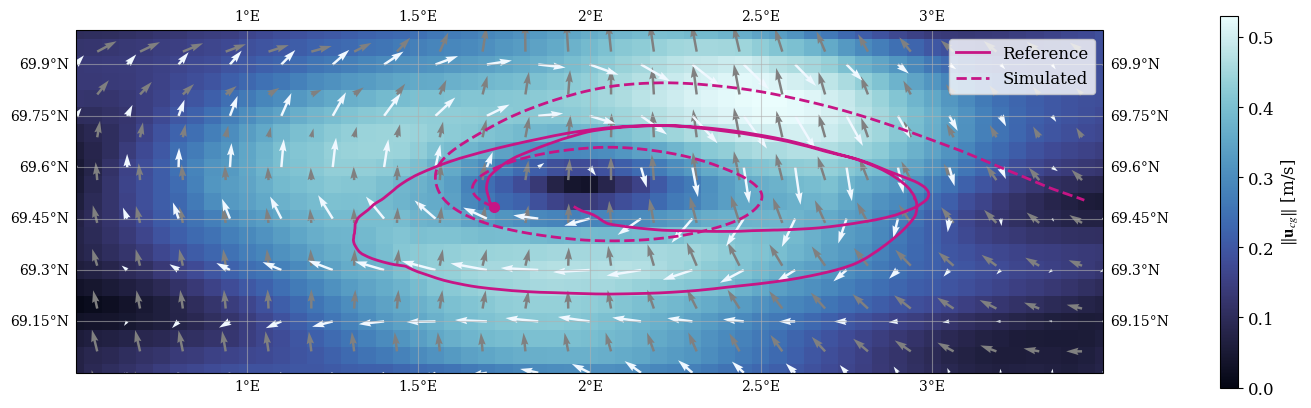

In [36]:
#fig = plt.figure(figsize=(15, 10))

#ax=fig.add_subplot(projection=ccrs.PlateCarree())
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    
#fig, ax = plt.subplots(
#    figsize=(15, 10)
#)

im=ax.pcolormesh(
        vardyn_ds.lon,
        vardyn_ds.lat,
        np.sqrt(vardyn_ds.u**2 + vardyn_ds.v**2)[2, ...],
        #vmax=.5,
        vmin=0,
        cmap=cmo.ice
)

#im = ax.pcolormesh(lon_wind, lat_wind, jnp.sqrt(u_wind[0] ** 2 + v_wind[0] ** 2), vmin=0, cmap=cmo.ice)

quiver = ax.quiver(lon_wind, lat_wind,u_wind[0], v_wind[0], scale=150, color='gray')
num = 3
quiver = ax.quiver(vardyn_ds.lon[::num], vardyn_ds.lat[::num],vardyn_ds.u[0][::num, ::num], vardyn_ds.v[0][::num, ::num], scale=15, color='aliceblue')
#quiver = ax.quiver(ecmwf_wind_gridded.coordinates['longitude']._values, ecmwf_wind_gridded.coordinates['latitude']._values,ecmwf_wind_gridded.fields['u']._values[0], ecmwf_wind_gridded.fields['v']._values[0], scale=15, color='red')

ax.gridlines(alpha=0.6, draw_labels=True)

ax.plot(melodi_traj.value[:,1], melodi_traj.value[:,0], c='mediumvioletred', label='Reference', linewidth=2)
#ax.plot(traj_mr_tot.value[:,1], traj_mr_tot.value[:,0], '--', c='mediumvioletred',    label='Simulated', linewidth = 3)
ax.plot(traj_mr_tot.value[:-100,1], traj_mr_tot.value[:-100,0], '--', c='mediumvioletred',    label='Simulated', linewidth = 2)
#ax.plot(traj_mr_tot_omb.value[:,1], traj_mr_tot_omb.value[:,0], '--', c='green',    label='Simulated', linewidth = 3)
ax.plot(traj_mr_tot.value[0,1], traj_mr_tot.value[0,0], 'o', c='mediumvioletred')
#ax.plot(traj_mr_tot_leeway.value[:,1], traj_mr_tot_leeway.value[:,0], '--', c='green',    label='Simulated', linewidth = 3)
#ax.scatter(melodi_traj.value[:,1], melodi_traj.value[:,0], c='tab:orange', s=10)
#ax.scatter(traj_mr_tot.value[:,1], traj_mr_tot.value[:,0], c='tab:red', s=10)
#ax.scatter(traj_mr_tot_leeway.value[:,1], traj_mr_tot_leeway.value[:,0], c='red', s=0.1)
#ax.scatter(omb_traj.value[:,1], omb_traj.value[:,0], c='red', s=1)
#ax.set_xlabel('longitude [°]')
#ax.set_ylabel('latitude [°]')
#ax.axis('equal')

ax.legend(loc='upper right')
ax.set_xlim([0.5,3.5]) 
ax.set_ylim([69,70])
fig.colorbar(im, fraction=0.016, pad=0.1, label='$\| \mathbf{u}_{cg} \|$ [m/s]')
#plt.grid()
ax.coastlines()
plt.savefig('/home/samantha/Desktop/MR_Lofoten.png')
#plt.show()